In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


In [48]:
isro_file = 'output.xlsx'
df_combined = pd.read_excel(isro_file)
df_combined['Date and Time'] = pd.to_datetime(df_combined['Date and Time'])
df_combined.set_index('Date and Time', inplace=True)


In [49]:
# Filter the dataset for one specific station (e.g., "APTFL")
Station = 'ABC_REN_RJ01'
features = [f'GHI_{Station}', f'Temperature_{Station}']
target = f'MW_{Station}'
df_combined = df_combined[features + [target]]
station_data = df_combined.copy()
station_data = station_data.reset_index()
#Ensure the datetime format is consistent
#station_data['Date and Time'] = pd.to_datetime(station_data['Date and Time'], format="%d-%m-%Y %H:%M", dayfirst=True)

station_data.columns = ['DateTime', 'GHI', 'Temperature', 'Generation']
# Extract the hour as a feature
station_data['Hour'] = station_data['DateTime'].dt.hour
station_data['GHI_Lag1']    = station_data['GHI'].shift(1)
station_data['GHI_Rolling'] = station_data['GHI'].rolling(window=3, min_periods=1).mean()
station_data = station_data[(station_data['Hour'] >= 6) & (station_data['Hour'] <= 19)]
len(station_data)


20384

In [50]:
def handle_missing_data(station_data):
    station_data.interpolate(method='linear', inplace=True)
    station_data.fillna(method='bfill', inplace=True)  # Backfill if interpolation leaves NaN
    station_data.fillna(method='ffill', inplace=True)  # Forward fill if necessary
    return station_data
station_data = handle_missing_data(station_data)

/tmp/ipython-input-50-746033763.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data.fillna(method='bfill', inplace=True)  # Backfill if interpolation leaves NaN
/tmp/ipython-input-50-746033763.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data.fillna(method='ffill', inplace=True)  # Forward fill if necessary


In [51]:
# Prepare features (GHI, Temperature, Hour) and target (Generation)
X_isro = station_data[['GHI', 'Temperature', 'Hour','GHI_Lag1','GHI_Rolling']].values
y_isro = station_data['Generation'].values
len(y_isro)

20384

In [52]:
scaler_X_isro = MinMaxScaler()
scaler_y_isro = MinMaxScaler()

X_scaled_isro = scaler_X_isro.fit_transform(X_isro)
y_scaled_isro = scaler_y_isro.fit_transform(y_isro.reshape(-1, 1))

# Get indices
train_idx, test_idx = train_test_split(np.arange(len(X_scaled_isro)), test_size=0.2, random_state=42)

# Use indices to split the data
X_train_isro, X_test_isro = X_scaled_isro[train_idx], X_scaled_isro[test_idx]
y_train_isro, y_test_isro = y_scaled_isro[train_idx], y_scaled_isro[test_idx]

# Reshape input data to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped_isro = X_train_isro.reshape((X_train_isro.shape[0], X_train_isro.shape[1], 1))
X_test_reshaped_isro = X_test_isro.reshape((X_test_isro.shape[0], X_test_isro.shape[1], 1))

In [55]:
# Define the LSTM model for ISRO data
model_isro = Sequential()

model_isro.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_reshaped_isro.shape[1], 1)))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=True))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=True))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=False))
model_isro.add(Dropout(0.3))

model_isro.add(Dense(units=1, activation='relu'))

# Compile the ISRO model
model_isro.compile(optimizer='adam', loss='mean_squared_error')

# Train the ISRO model with early stopping
early_stopping_isro = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_isro = model_isro.fit(X_train_reshaped_isro, y_train_isro, epochs=100, batch_size=32, validation_split=0.2,
                              callbacks=[early_stopping_isro], verbose=1)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


408/408 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - loss: 0.0868 - val_loss: 0.0384
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0421 - val_loss: 0.0345
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0365 - val_loss: 0.0341
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0339 - val_loss: 0.0315
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0360 - val_loss: 0.0309
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0336 - val_loss: 0.0310
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0331 - val_loss: 0.0335
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0330 - val_loss: 0.0321
Epoch 9/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0322 - val_loss: 0.0304
Epoch 10/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0320 - val_loss: 0.0313
Epoch 11/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0323 - val_loss: 0.0318
Epoch 12/100
408/408 ━━━━━━━━━━━━━━

In [56]:
# Make predictions on the test set
y_pred_scaled_isro = model_isro.predict(X_test_reshaped_isro)

# Inverse transform the predictions and the actual values
y_pred_isro = scaler_y_isro.inverse_transform(y_pred_scaled_isro)
y_test_actual_isro = scaler_y_isro.inverse_transform(y_test_isro)

# Extract corresponding datetime from the test set using test_idx
test_dates = station_data['DateTime'].iloc[test_idx]

# Calculate Evaluation Metrics (MAE and R²)
mae_isro = mean_absolute_error(y_test_actual_isro, y_pred_isro)
r2_isro = r2_score(y_test_actual_isro, y_pred_isro)

print(f"Mean Absolute Error (MAE): {mae_isro:.4f}")
print(f"R² Score: {r2_isro:.4f}")

# Print the first 10 actual vs predicted values with timestamps
print("Time: Actual vs Predicted values:")
for i in range(30):
    print(f"Time: {test_dates.iloc[i]}, Actual: {y_test_actual_isro[i][0]:.3f}, Predicted: {y_pred_isro[i][0]:.6f}")


128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Mean Absolute Error (MAE): 29.1078
R² Score: 0.8129
Time: Actual vs Predicted values:
Time: 2025-03-08 17:30:00, Actual: 155.264, Predicted: 67.694145
Time: 2024-06-24 11:00:00, Actual: 263.680, Predicted: 282.380402
Time: 2024-08-18 07:45:00, Actual: 82.176, Predicted: 58.953972
Time: 2024-11-13 12:00:00, Actual: 302.336, Predicted: 270.280365
Time: 2024-11-13 12:15:00, Actual: 302.592, Predicted: 267.847870
Time: 2024-06-12 08:45:00, Actual: 182.656, Predicted: 172.885132
Time: 2025-03-11 15:15:00, Actual: 132.096, Predicted: 198.861374
Time: 2024-10-25 18:45:00, Actual: 3.669, Predicted: 0.993114
Time: 2024-04-22 07:30:00, Actual: 71.680, Predicted: 41.151043
Time: 2025-01-04 14:30:00, Actual: 252.416, Predicted: 227.096222
Time: 2024-05-27 07:45:00, Actual: 102.656, Predicted: 92.436394
Time: 2024-10-13 12:15:00, Actual: 161.408, Predicted: 269.584778
Time: 2024-06-27 08:00:00, Actual: 110.080, Predicted: 56.743465
Time: 2024-06-16 06:30:00

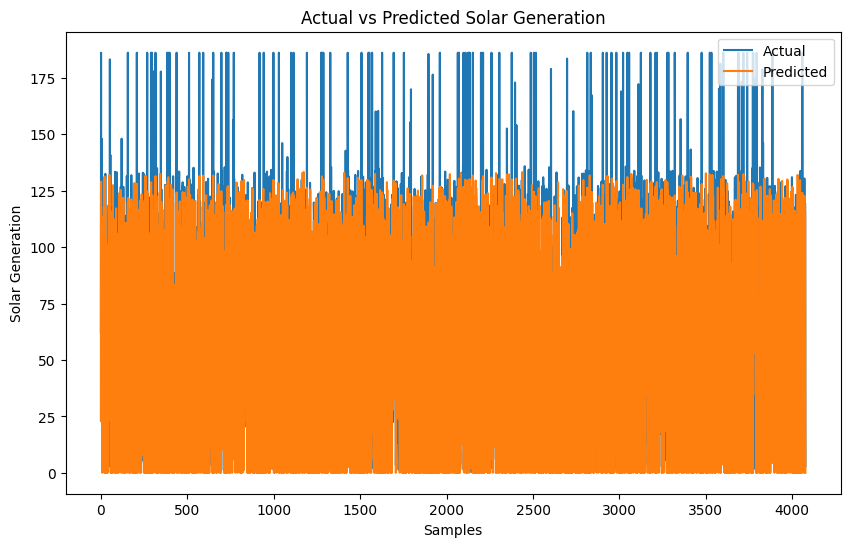

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_isro, label='Actual')
plt.plot(y_pred_isro, label='Predicted')
plt.title('Actual vs Predicted Solar Generation')
plt.xlabel('Samples')
plt.ylabel('Solar Generation')
plt.legend()
plt.show()

In [7]:
features = ['GHI_ACME', 'Temperature_ACME']
target = 'MW_ACME'
df_combined = df_combined[features + [target]]
station_data = df_combined.copy()
station_data = station_data.reset_index()
#Ensure the datetime format is consistent
#station_data['Date and Time'] = pd.to_datetime(station_data['Date and Time'], format="%d-%m-%Y %H:%M", dayfirst=True)

station_data.columns = ['DateTime', 'GHI', 'Temperature', 'Generation']
# Extract the hour as a feature
station_data['Hour'] = station_data['DateTime'].dt.hour
station_data['GHI_Lag1']    = station_data['GHI'].shift(1)
station_data['GHI_Rolling'] = station_data['GHI'].rolling(window=3, min_periods=1).mean()
station_data = station_data[(station_data['Hour'] >= 6) & (station_data['Hour'] <= 19)]
len(station_data)


20384

In [8]:
def handle_missing_data(station_data):
    station_data.interpolate(method='linear', inplace=True)
    station_data.fillna(method='bfill', inplace=True)  # Backfill if interpolation leaves NaN
    station_data.fillna(method='ffill', inplace=True)  # Forward fill if necessary
    return station_data
station_data = handle_missing_data(station_data)

/tmp/ipython-input-8-746033763.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data.fillna(method='bfill', inplace=True)  # Backfill if interpolation leaves NaN
/tmp/ipython-input-8-746033763.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  station_data.fillna(method='ffill', inplace=True)  # Forward fill if necessary


In [9]:
X_isro = station_data[['GHI', 'Temperature', 'Hour','GHI_Lag1','GHI_Rolling']].values
y_isro = station_data['Generation'].values
len(y_isro)

20384

218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


In [10]:
scaler_X_isro = MinMaxScaler()
scaler_y_isro = MinMaxScaler()

X_scaled_isro = scaler_X_isro.fit_transform(X_isro)
y_scaled_isro = scaler_y_isro.fit_transform(y_isro.reshape(-1, 1))

# Get indices
train_idx, test_idx = train_test_split(np.arange(len(X_scaled_isro)), test_size=0.2, random_state=42)

# Use indices to split the data
X_train_isro, X_test_isro = X_scaled_isro[train_idx], X_scaled_isro[test_idx]
y_train_isro, y_test_isro = y_scaled_isro[train_idx], y_scaled_isro[test_idx]

# Reshape input data to be 3D [samples, timesteps, features] for LSTM
X_train_reshaped_isro = X_train_isro.reshape((X_train_isro.shape[0], X_train_isro.shape[1], 1))
X_test_reshaped_isro = X_test_isro.reshape((X_test_isro.shape[0], X_test_isro.shape[1], 1))

In [11]:
# Define the LSTM model for ISRO data
model_isro = Sequential()

model_isro.add(LSTM(units=100, return_sequences=True, input_shape=(X_train_reshaped_isro.shape[1], 1)))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=True))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=True))
model_isro.add(Dropout(0.3))
model_isro.add(LSTM(units=50, return_sequences=False))
model_isro.add(Dropout(0.3))

model_isro.add(Dense(units=1, activation='relu'))

# Compile the ISRO model
model_isro.compile(optimizer='adam', loss='mean_squared_error')

# Train the ISRO model with early stopping
early_stopping_isro = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_isro = model_isro.fit(X_train_reshaped_isro, y_train_isro, epochs=100, batch_size=32, validation_split=0.2,
                              callbacks=[early_stopping_isro], verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0475 - val_loss: 0.0225
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0238 - val_loss: 0.0210
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0218 - val_loss: 0.0199
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.0214 - val_loss: 0.0196
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0219 - val_loss: 0.0193
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0210 - val_loss: 0.0205
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0207 - val_loss: 0.0196
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0206 - val_loss: 0.0195
Epoch 9/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0193 - val_loss: 0.0198
Epoch 10/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0207 - val_loss: 0.0194
Epoch 11/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0197 - val_loss: 0.0197
Epoch 12/100
408/408 ━━━

In [12]:
# Make predictions on the test set
y_pred_scaled_isro = model_isro.predict(X_test_reshaped_isro)

# Inverse transform the predictions and the actual values
y_pred_isro = scaler_y_isro.inverse_transform(y_pred_scaled_isro)
y_test_actual_isro = scaler_y_isro.inverse_transform(y_test_isro)

# Extract corresponding datetime from the test set using test_idx
test_dates = station_data['DateTime'].iloc[test_idx]

# Calculate Evaluation Metrics (MAE and R²)
mae_isro = mean_absolute_error(y_test_actual_isro, y_pred_isro)
r2_isro = r2_score(y_test_actual_isro, y_pred_isro)

print(f"Mean Absolute Error (MAE): {mae_isro:.4f}")
print(f"R² Score: {r2_isro:.4f}")

# Print the first 10 actual vs predicted values with timestamps
print("Time: Actual vs Predicted values:")
for i in range(30):
    print(f"Time: {test_dates.iloc[i]}, Actual: {y_test_actual_isro[i][0]:.3f}, Predicted: {y_pred_isro[i][0]:.6f}")



128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean Absolute Error (MAE): 30.7043
R² Score: 0.7138
Time: Actual vs Predicted values:
Time: 2025-03-08 17:30:00, Actual: 117.632, Predicted: 58.324551
Time: 2024-06-24 11:00:00, Actual: 370.176, Predicted: 227.725784
Time: 2024-08-18 07:45:00, Actual: 77.952, Predicted: 77.615440
Time: 2024-11-13 12:00:00, Actual: 225.152, Predicted: 180.090698
Time: 2024-11-13 12:15:00, Actual: 224.512, Predicted: 181.168488
Time: 2024-06-12 08:45:00, Actual: 360.873, Predicted: 159.865112
Time: 2025-03-11 15:15:00, Actual: 111.104, Predicted: 95.931671
Time: 2024-10-25 18:45:00, Actual: 6.948, Predicted: 17.069340
Time: 2024-04-22 07:30:00, Actual: 62.080, Predicted: 80.584251
Time: 2025-01-04 14:30:00, Actual: 64.768, Predicted: 147.065277
Time: 2024-05-27 07:45:00, Actual: 96.128, Predicted: 123.964569
Time: 2024-10-13 12:15:00, Actual: 152.832, Predicted: 209.480911
Time: 2024-06-27 08:00:00, Actual: 213.818, Predicted: 121.549301
Time: 2024-06-16 06:30:00,

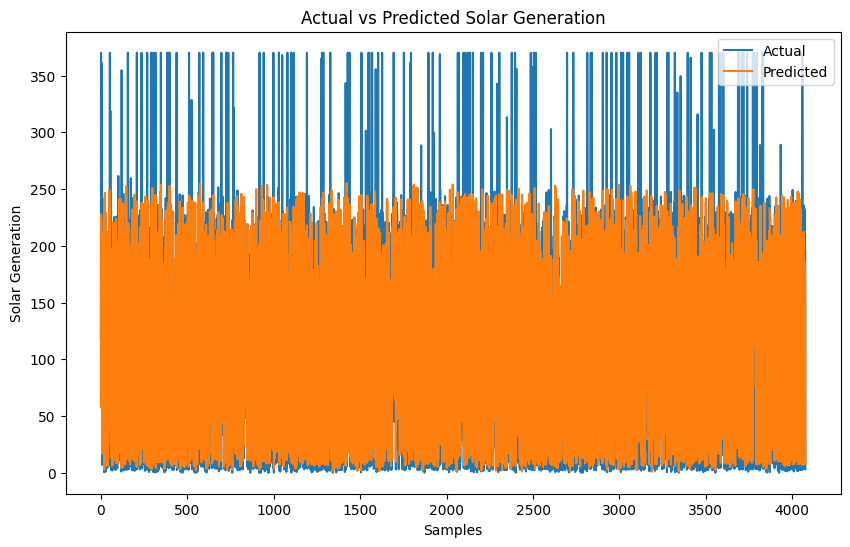

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_isro, label='Actual')
plt.plot(y_pred_isro, label='Predicted')
plt.title('Actual vs Predicted Solar Generation')
plt.xlabel('Samples')
plt.ylabel('Solar Generation')
plt.legend()
plt.show()
